Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [395]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [88]:
RSEED = 50

### Importing data and data cleaning

In [336]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=['rgiid', 'x', 'y'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  0.005069   
               524681.113471 8.539955e+06  432.421537  0.005068  0.005068   
               524704.704977 8.539980e+06  432.740057  0.005068  0.005068   
               524728.296484 8.540004e+06  433.058576  0.005067  0.005067   
               524751.887990 8.540028e+06  433.377096  0.005067  0.005067   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612  0.004612   
               534310.362510 8.675249e+06  627.625366  0.004614  0.004614   
               534309.250485 8.675291e+06  627.625366  0.004618  0.004618   
               534308.138459 8.675333e+06  627.625366  0.004620  0.004620   
               534307.026431 8.675375e+06  627.625366  0.004621  0.004621   

         

In [337]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [338]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['Unnamed: 0', 'ELA', 'beta', 'Name', 'Area'])
df.dropna(how='any', inplace=True)

In [339]:
df

Surge  Slope  TermType        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06      0   13.8         0  889.68555   
               524681.113471 8.539955e+06      0   13.8         0  882.06460   
               524704.704977 8.539980e+06      0   13.8         0  882.06460   
               524728.296484 8.540004e+06      0   13.8         0  882.06460   
               524751.887990 8.540028e+06      0   13.8         0  881.31860   
...                                          ...    ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06      3   11.7         0  237.64468   
               534310.362510 8.675249e+06      3   11.7         0  233.07228   
               534309.250485 8.675291e+06      3   11.7         0  233.07228   
               534308.138459 8.675333e+06      3   11.7         0  233.18828   
               534307.026431 8.675375e+06      3   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                cmb  width_centerline  \
rgiid          x             y                                          
RGI60-07.00004 524657.521964 8.539931e+06  0.005069        279.780932   
               524681.113471 8.539955e+06  0.005068        295.980219   
               524704.704977 8.539980e+06  0.005068        330.851846   
               524728.296484 8.540004e+06  0.005067        342.886985   
               524751.887990 8.540028e+06  0.005067        336.403639   
...                                             ...               ...   
RGI60-07.01567 534269.488654 8.675206e+06  0.004612        278.553621   
               534310.362510 8.675249e+06  0.004614        256.755923   
               534309.250485 8.675291e+06  0.004618        238.477978   
               534308.138459 8.675333e+06  0.004620        226.342325   
               534307.026431 8.675375e+06  0.004621        215.631320   

                                             Runoff         WH         WHsin  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06  1.100061  11.052210   6683.732353   
               524681.113471 8.539955e+06  1.094416   9.567670   8640.744376   
               524704.704977 8.539980e+06  1.088771  10.694908   9658.774620   
               524728.296484 8.540004e+06  1.083127  11.083948  10010.124318   
               524751.887990 8.540028e+06  1.077530   9.699834  11010.043050   
...                                             ...        ...           ...   
RGI60-07.01567 534269.488654 8.675206e+06  2.123592   5.529005 -10693.410549   
               534310.362510 8.675249e+06  2.127417   5.495975  -9139.908345   
               534309.250485 8.675291e+06  2.076787   5.104727  -8489.256385   
               534308.138459 8.675333e+06  2.005969   4.799500  -8133.568561   
               534307.026431 8.675375e+06  1.935151   4.572378  -7748.670623   

                                   

In [315]:
df_main.groupby('Surge').count()

,Unnamed: 0,x,y,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff
Surge,,,,,,,,,,,,,,,
0,68813,68813,68813,68813,68813,68813,48314,68813,68813,68813,68752,68752,68752,68707,68813
3,10906,10906,10906,10906,10906,10906,10827,10906,10906,10906,10897,10897,10897,10905,10906


In [340]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    10897
Name: label, dtype: int64

In [341]:
df[df['label']==1].shape[0]

10897

In [96]:
df.shape

(79572, 13)

### Resampled

In [342]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [326]:
df_downsampled.shape

(21794, 14)

In [343]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [100]:
train_labels.sum()/train_labels.shape[0]

0.5000327761389708

In [101]:
test_labels.sum()/test_labels.shape[0]

0.499923535708824

In [102]:
missing_data = df.isna()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Area
False    21794
Name: Area, dtype: int64

Slope
False    21794
Name: Slope, dtype: int64

TermType
False    21794
Name: TermType, dtype: int64

bed
False    21794
Name: bed, dtype: int64

thickness
False    21794
Name: thickness, dtype: int64

surface_elevation
False    21794
Name: surface_elevation, dtype: int64

cmb
False    21794
Name: cmb, dtype: int64

width_centerline
False    21794
Name: width_centerline, dtype: int64

Runoff
False    21794
Name: Runoff, dtype: int64

WH
False    21794
Name: WH, dtype: int64

WHsin
False    21794
Name: WHsin, dtype: int64

dummy
False    21794
Name: dummy, dtype: int64



In [17]:
4081/81683

0.04996143628417174

In [344]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'cmb',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [345]:
train.head()

,,,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00280,553575.917322,8.628668e+06,14.8,1,132.84703,130.152970,263.00000,0.005335,1305.357126,2.412571,10.029407,133920.957449,0.343805
RGI60-07.00657,419515.543965,8.802430e+06,13.5,0,47.77221,84.227790,132.00000,0.006131,2016.165884,3.202466,23.937063,136496.418069,0.887510
RGI60-07.00083,649498.861574,8.940567e+06,11.0,0,222.65680,70.991240,293.64804,0.003346,728.847514,1.134672,10.266725,-51741.282092,0.843421
RGI60-07.01104,506830.011773,8.674207e+06,19.1,0,446.54710,9.427357,455.97446,0.004964,335.666606,1.690846,35.605590,784.258694,0.754423
RGI60-07.00886,573583.886957,8.822602e+06,9.2,0,225.56620,86.810680,312.37686,0.003366,864.160144,1.346279,9.954537,16720.829064,0.474813


In [346]:
train_labels.shape

(15255,)

In [347]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00406,558798.526104,8.664137e+06,12.2,0,282.44528,44.135950,326.58124,0.005015,857.464174,2.305615,19.427795,-13557.185729,0.649424
RGI60-07.00762,448997.437378,8.852141e+06,15.6,0,252.57115,25.428846,278.00000,0.004105,826.454593,1.475203,32.500672,2264.527758,0.146023
RGI60-07.00724,424986.267372,8.835152e+06,15.6,0,219.40239,55.597607,275.00000,0.005302,622.120229,2.572455,11.189694,3727.025996,0.668150
RGI60-07.00870,525560.243539,8.853051e+06,9.1,0,279.27737,259.480930,538.75830,0.003882,6074.690291,1.027072,23.410932,502983.990515,0.168607
RGI60-07.01566,499825.135799,8.651795e+06,10.6,0,549.89746,24.503185,574.40063,0.004093,1246.102431,2.213000,50.854713,-28175.543399,0.024673


# Gradient boosting

In [348]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [349]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test[test.columns], label=test_labels)

In [350]:
train_labels.shape

(15255,)

In [351]:
test_labels.shape

(6539,)

In [352]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

/usr/local/lib64/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [359]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00406,558798.526104,8.664137e+06,12.2,0,282.44528,44.135950,326.58124,0.005015,857.464174,2.305615,19.427795,-13557.185729,0.649424
RGI60-07.00762,448997.437378,8.852141e+06,15.6,0,252.57115,25.428846,278.00000,0.004105,826.454593,1.475203,32.500672,2264.527758,0.146023
RGI60-07.00724,424986.267372,8.835152e+06,15.6,0,219.40239,55.597607,275.00000,0.005302,622.120229,2.572455,11.189694,3727.025996,0.668150
RGI60-07.00870,525560.243539,8.853051e+06,9.1,0,279.27737,259.480930,538.75830,0.003882,6074.690291,1.027072,23.410932,502983.990515,0.168607
RGI60-07.01566,499825.135799,8.651795e+06,10.6,0,549.89746,24.503185,574.40063,0.004093,1246.102431,2.213000,50.854713,-28175.543399,0.024673


In [193]:
np.arange(0, probabilities_xgboost.shape[0]+1, 1)

array([   0,    1,    2, ..., 6537, 6538, 6539])

In [311]:
df_test.shape

(6539, 1)

In [366]:
index = test.index
index

MultiIndex([('RGI60-07.00406',  558798.5261044839, 8664136.652496597),
            ('RGI60-07.00762',  448997.4373776433, 8852141.018923216),
            ('RGI60-07.00724', 424986.26737215155, 8835151.780417366),
            ('RGI60-07.00870',  525560.2435389693, 8853050.645205105),
            ('RGI60-07.01566',  499825.1357992821, 8651795.446349898),
            ('RGI60-07.00275',  569087.6373499867, 8639566.455186924),
            ('RGI60-07.01206',  496951.6228797978,  8818919.20838297),
            ('RGI60-07.00744', 458840.19262354326,  8824089.57972858),
            ('RGI60-07.01229',  512465.3535806692, 8761713.916942004),
            ('RGI60-07.00147',  516540.8995101832,  8620465.65863179),
            ...
            ('RGI60-07.00025',  666190.0726743622, 8815515.629822362),
            ('RGI60-07.01100', 486639.77219799784, 8639932.121301498),
            ('RGI60-07.00434',   566525.263104095, 8686640.909941556),
            ('RGI60-07.01466',  454354.8735761452, 8755798.57

In [369]:
df_test_mean

,Surge
rgiid,
RGI60-07.00004,0
RGI60-07.00006,0
RGI60-07.00008,0
RGI60-07.00010,0
RGI60-07.00024,0
...,...
RGI60-07.01562,0
RGI60-07.01563,0
RGI60-07.01564,1


In [368]:
df_test = pd.DataFrame({'Surge': test_labels}, index=index)
df_test_mean = df_test.groupby('rgiid').mean()
df_test
# df_test_mean = df_test.groupby('rgiid').mean()

,,,Surge
rgiid,x,y,
RGI60-07.00406,558798.526104,8.664137e+06,1
RGI60-07.00762,448997.437378,8.852141e+06,0
RGI60-07.00724,424986.267372,8.835152e+06,0
RGI60-07.00870,525560.243539,8.853051e+06,1
RGI60-07.01566,499825.135799,8.651795e+06,0
...,...,...,...
RGI60-07.00937,648445.942318,8.615404e+06,0
RGI60-07.00942,688677.902112,8.650632e+06,0
RGI60-07.00441,525190.281215,8.528187e+06,0


In [387]:
# predictions_xgboost = xgb.predict(dmatrix_test)
predictions_xgboost = xgb.predict(test)
probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(dmatrix_test)
prob_0 = []
prob_1 = []
for n in np.arange(0, probabilities_xgboost.shape[0], 1):
    prob_0.append(probabilities_xgboost[:][:][n][0])
    prob_1.append(probabilities_xgboost[:][:][n][1])
    
df_probability_surge = pd.DataFrame({'Probability_0':prob_0, 'Probability_1':prob_1, 'Predictions':predictions_xgboost}, index=index)
df_probability_surge.reset_index(['x', 'y'], inplace=True)

In [388]:
df_probability_surge

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00406,558798.526104,8.664137e+06,0.673523,0.326477,0
RGI60-07.00762,448997.437378,8.852141e+06,0.939825,0.060175,0
RGI60-07.00724,424986.267372,8.835152e+06,0.885507,0.114493,0
RGI60-07.00870,525560.243539,8.853051e+06,0.588969,0.411031,0
RGI60-07.01566,499825.135799,8.651795e+06,0.695132,0.304868,0
...,...,...,...,...,...
RGI60-07.00937,648445.942318,8.615404e+06,0.578888,0.421112,0
RGI60-07.00942,688677.902112,8.650632e+06,0.459002,0.540998,1
RGI60-07.00441,525190.281215,8.528187e+06,0.755804,0.244196,0


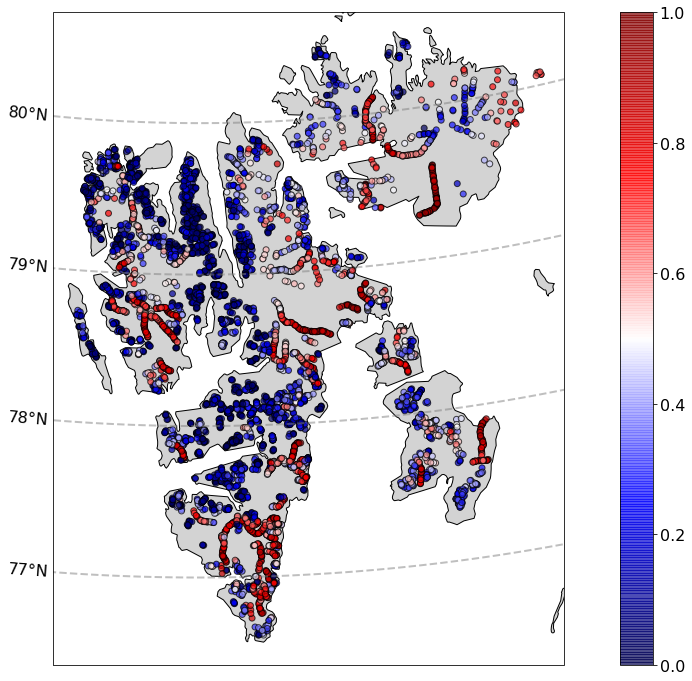

In [394]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

cbar = ax.scatter(df_probability_surge.x.values
        ,df_probability_surge.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=df_probability_surge.Probability_1
        , cmap = 'seismic'# symbol facecolor
        , edgecolor='black'                          # symbol edgecolor
        , alpha=0.7
        , vmin=0
        , vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

fig.colorbar(cbar)
# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
# ax.legend(fontsize=15)a

In [312]:
df.shape

(21794, 12)

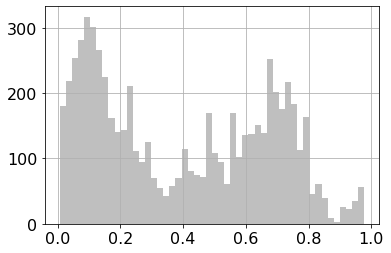

In [227]:
df_probability_surge.Probability_1.hist(bins=50, color='grey', alpha=0.5)

In [220]:
df_probability_surge_mean = df_probability_surge.groupby('rgiid').mean()
df_probability_surge_mean

,Probability_0,Probability_1,Predictions
rgiid,,,
RGI60-07.00004,0.963568,0.036432,0.0
RGI60-07.00006,0.724004,0.275996,0.0
RGI60-07.00008,0.813998,0.186002,0.0
RGI60-07.00010,0.974641,0.025359,0.0
RGI60-07.00024,0.988147,0.011853,0.0
...,...,...,...
RGI60-07.01562,0.879937,0.120063,0.0
RGI60-07.01563,0.889531,0.110469,0.0
RGI60-07.01564,0.306923,0.693077,1.0


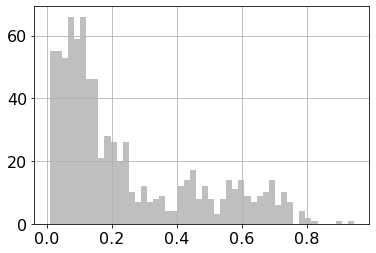

In [226]:
df_probability_surge_mean.Probability_1.hist(bins=50, color='grey', alpha=0.5)

In [262]:
df_main_mean = df_main.groupby('rgiid').mean()
df_main_mean

,Unnamed: 0,x,y,Surge,Area,Slope,TermType,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff
rgiid,,,,,,,,,,,,,,,
RGI60-07.00004,223.5,525074.831142,8.540094e+06,0.0,1.044,13.8,0.0,823.260914,30.600193,853.861111,434.226192,0.005051,0.005051,425.276089,1.135406
RGI60-07.00006,342.5,535908.807782,8.540043e+06,0.0,13.618,12.6,1.0,249.308085,56.154878,305.462963,492.159680,0.006963,0.006963,1156.936330,2.196162
RGI60-07.00008,499.0,527557.142234,8.551328e+06,0.0,1.577,14.8,0.0,173.741327,20.128238,193.869565,425.626190,0.006616,0.006616,587.915603,2.628263
RGI60-07.00010,636.0,519430.937310,8.551705e+06,0.0,1.456,16.0,0.0,315.729296,19.246014,334.975309,428.533844,0.006769,0.006769,633.852539,2.321316
RGI60-07.00024,1483.5,526981.868732,8.586109e+06,0.0,1.025,19.4,0.0,396.148187,13.090450,409.238636,524.822033,0.007053,0.007053,327.444479,1.937088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01562,130388.5,589779.045033,8.789835e+06,0.0,3.475,10.7,0.0,241.288306,59.636145,300.924452,540.952818,0.003311,0.003311,1023.288889,1.402359
RGI60-07.01563,130479.5,578568.908265,8.789898e+06,0.0,8.875,11.9,0.0,260.291092,71.350877,331.641968,531.299076,0.003654,0.003654,827.390012,1.483290
RGI60-07.01564,130619.5,568867.596205,8.776534e+06,3.0,330.996,6.0,0.0,534.338951,129.530531,663.869488,615.056881,0.002880,0.002880,4066.157997,1.225338


In [275]:
df_probability_surge_mean['New_predict'] = df_probability_surge_mean['Probability_1'].apply(lambda x: 1 if x>0.6 else 0)
df_probability_surge_mean

,Probability_0,Probability_1,Predictions,New_predict
rgiid,,,,
RGI60-07.00004,0.963568,0.036432,0.0,0
RGI60-07.00006,0.724004,0.275996,0.0,0
RGI60-07.00008,0.813998,0.186002,0.0,0
RGI60-07.00010,0.974641,0.025359,0.0,0
RGI60-07.00024,0.988147,0.011853,0.0,0
...,...,...,...,...
RGI60-07.01562,0.879937,0.120063,0.0,0
RGI60-07.01563,0.889531,0.110469,0.0,0
RGI60-07.01564,0.306923,0.693077,1.0,1


In [276]:
df_reduced = pd.DataFrame({'x':df_main_mean['x'], 'y':df_main_mean['y']})
df_reduced
df_map = pd.concat([df_probability_surge_mean, df_reduced], axis=1, join="inner")
df_map

,Probability_0,Probability_1,Predictions,New_predict,x,y
rgiid,,,,,,
RGI60-07.00004,0.963568,0.036432,0.0,0,525074.831142,8.540094e+06
RGI60-07.00006,0.724004,0.275996,0.0,0,535908.807782,8.540043e+06
RGI60-07.00008,0.813998,0.186002,0.0,0,527557.142234,8.551328e+06
RGI60-07.00010,0.974641,0.025359,0.0,0,519430.937310,8.551705e+06
RGI60-07.00024,0.988147,0.011853,0.0,0,526981.868732,8.586109e+06
...,...,...,...,...,...,...
RGI60-07.01562,0.879937,0.120063,0.0,0,589779.045033,8.789835e+06
RGI60-07.01563,0.889531,0.110469,0.0,0,578568.908265,8.789898e+06
RGI60-07.01564,0.306923,0.693077,1.0,1,568867.596205,8.776534e+06


Text(0.6, 0.0, 'AUC = 0.89')

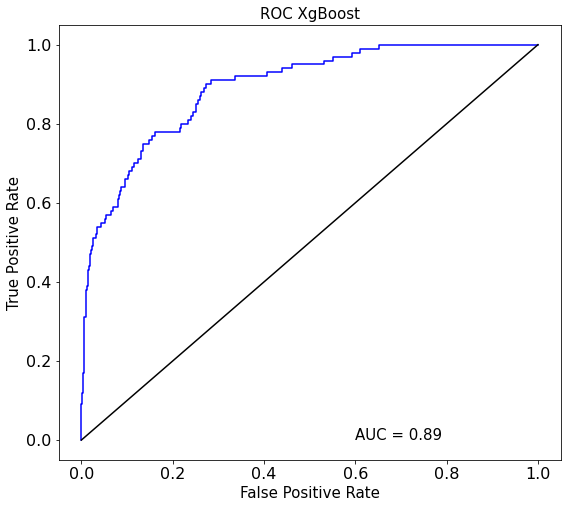

In [302]:
fpr, tpr, t = metrics.roc_curve(y_true=df_test_mean['Surge'], y_score=df_probability_surge_mean['Probability_1'])

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=df_test_mean['Surge'], y_score=df_probability_surge_mean['Probability_1']),2))
    , x=0.6, y=0.0, fontsize=15
)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax, color='b')

# Map of probability (mean over glaciers)

In [396]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import rioxarray as rxr

# from matplotlib import matplotlib.patches.Polygon

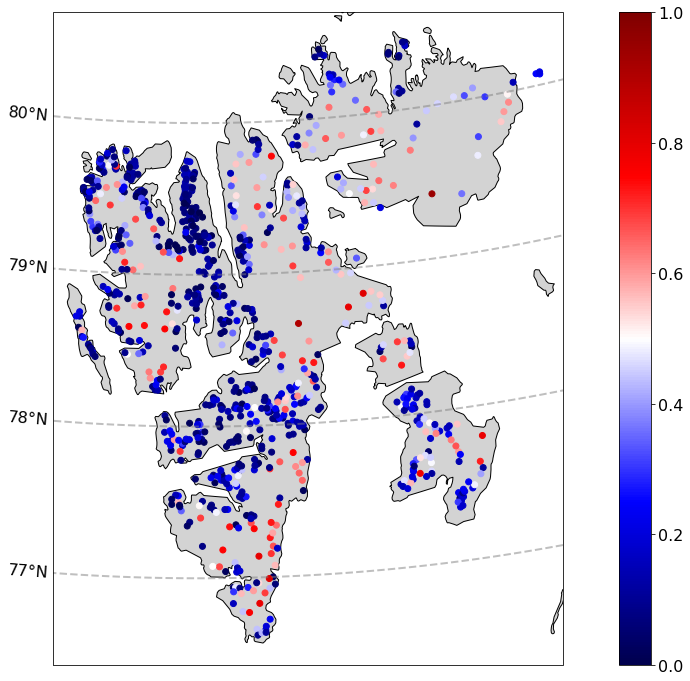

In [398]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

cbar = ax.scatter(df_map.x.values
        ,df_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=df_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

fig.colorbar(cbar)
# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
# ax.legend(fontsize=15)

Text(0.6, 0.0, 'AUC = 0.92')

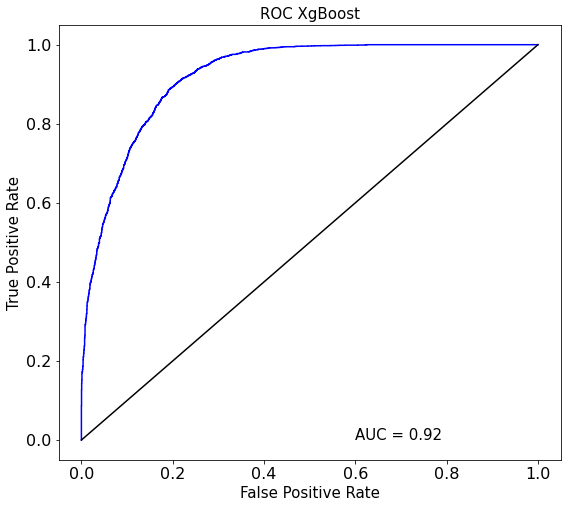

In [76]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

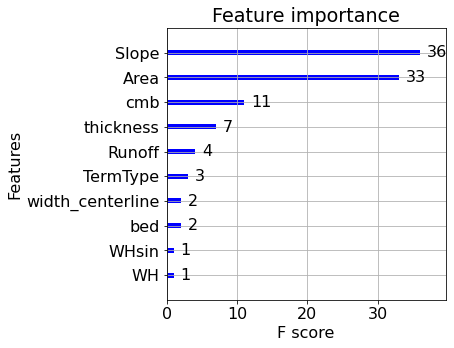

In [305]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax, color='b')

In [78]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.91


In [79]:
test_labels.dtype

dtype('int64')

Confusion matrix, without normalization
[[43  6]
 [11 38]]


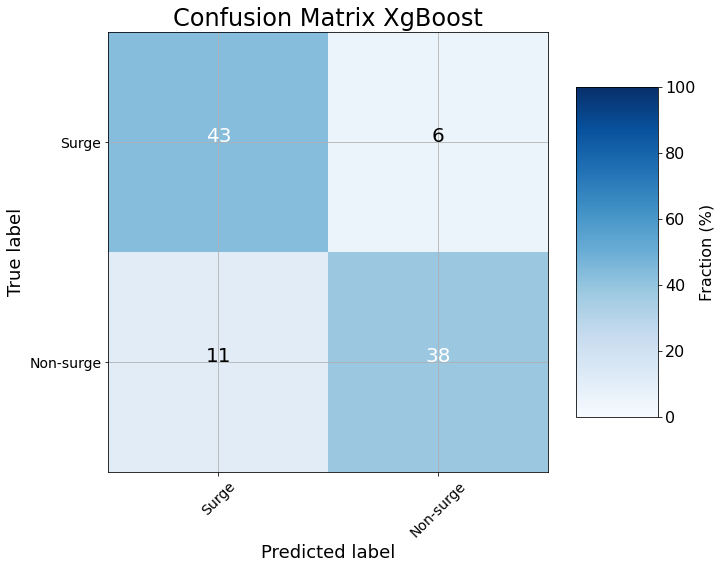

In [80]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8